# Main idea.

The main idea for this project, is to develop a sentiment classifier using **RNN** for the [Twitter sentiment analysis dataset](https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view), with LSTM/GRU cells. 

We'll do some expirements with all the possible hyperparameters, like the number of hidden layers, activation functions, loss functions, optimizers, etc. <!-- Also, we'll use pre-trained word embendding vectors, using [GloVe](https://nlp.stanford.edu/projects/glove/). -->

# (1) Preprocess Dataset:


Here, all the data preprocessing, such as text cleaning and dropping empty lines will take place. First, let's load and see the raw data.

In [1]:
import pandas as pd
from pandas import read_csv
import csv

In [2]:
LocationCSV = r'/content/SentimentTweets.csv'
tweets = pd.read_csv(LocationCSV, low_memory=False , quoting=csv.QUOTE_NONE, encoding='utf-8',  warn_bad_lines=False, error_bad_lines=False);   #Read csv file
tweets.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


So , the main goal here is to drop all the columns except the ones who contains the sentiment for each tweet. Thus, we'll keep the **target** and the **text** columns. Then, we'll do some text cleaning, in order to have a more appropriate dataset to work with.

In [3]:
import re
from bs4 import BeautifulSoup

#Natural Language Toolkit
import nltk
import nltk.corpus

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
def sum1forline(filename):                                                      #Calculating the rows in a csv file
    with open(filename) as f:
        total_lines = sum(1 for line in f)
    
    print("We have:", total_lines ,"rows in total")

In [5]:
def cleanCSV(tweets):                                                           #Drop useless columns
  
  df = tweets[['target','text']]
  df.shape
  columns_titles = ["text","target"]
  df=df.reindex(columns=columns_titles)
  df.columns = ['text', 'sentiment']
  df.shape
  df.loc[df["sentiment"]==4 , "sentiment"] = 'positive'
  df.loc[df['sentiment']==0 , "sentiment"] = 'negative'
  df.shape
  return df

In [6]:
def cleanText(tweets):
  tweets['text'] = tweets['text'].apply(lambda x: str(x).lower())                                                 #Make the text in lowercase

  tweets['text'] = tweets['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text().strip())                    #Removing HTML Tags

  tweets['text'] = tweets['text'].apply(lambda x: RemoveSpecialCharacters(x))                                     #Remove special characters (#!@%*& etc)

  tweets['text'] = tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))   #Removing stopwords

  tweets['text'] = tweets['text'].apply(lambda x: removeNumbers(x))                                               #Removing numbers

  #Steeming: "rained" , "raining" , "rain" converting into: "rain".

  tweets['text_tokens'] = tweets['text'].apply(lambda x: word_tokenize(x))
  #Uncomment the next lines if you want to choose steeming over leematization

  # <-->
  tweets['text_tokens_final'] = tweets['text_tokens'].apply(lambda x: word_stemmer(x))
  # <-->

  #Leematization: "rocks" : rock , "corpora" : corpus, "better" : good.
  #Comment the next line if you want to choose steeming over leematization

  # <-->
  # tweets['text_tokens_final'] = tweets['text_tokens'].apply(lambda x: word_lemmatizer(x))
  # <-->

  #Final text

  tweets['final_text'] = tweets['text_tokens_final'].apply(lambda x: list2string(x))

  tweets['final_text'] =  tweets['final_text'].apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))                      #Remove all the single characters from a string

  tweets['final_text'] = tweets['final_text'].apply(lambda x: re.sub(' +', ' ', x))                                 #Replace multiple whitespaces

  #Clean the csv file from odd columns
  tweets = tweets.drop(['text', 'text_tokens', 'text_tokens_final'], axis=1)
  
  columns_titles = ["final_text","sentiment"]
  tweets=tweets.reindex(columns=columns_titles)

  tweets.columns= ['text', 'sentiment']                        

  return tweets

def removeNumbers(text):
  result = ''.join([i for i in text if not i.isdigit()])
  return result

def RemoveSpecialCharacters(x):

  cleanString = re.sub('\W+',' ', x )
  cleanString= ' '.join(cleanString.split())
  return cleanString

def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

def list2string(list):
  # initialize an empty string 
  str1 = " " 
    
  # return string   
  return (str1.join(list)) 

In [7]:
sum1forline(LocationCSV)
tweets = cleanCSV(tweets)
tweets = cleanText(tweets)
tweets.head()

We have: 86682 rows in total


,text,sentiment
0,brokenpromis,negative
1,david carradin sad thai law sure fowl play man...,negative
2,tell bro say congrat,positive
3,littlefluffycat inde,positive
4,complet race life min girli work fun bloodi ho...,positive


Now, we must split our dataset into:

*   Training dataset
*   Validation dataset
*   Test dataset

The most part from the tweets, will be donated to test dataset. To be more specific, 90% of the dataset will be given into test. The other 10%, will be given to train and valid. From this 10%, each dataset will take 80% and 20% share, respectively.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_raw = tweets 

# Convert Positive = 1 and Negative = 0 
df_raw['sentiment'] = (df_raw['sentiment'] == 'positive').astype('int')

# Remove empty sentences
df_raw.drop( df_raw[df_raw.text.str.len() < 1].index, inplace=True)

# Split according to label
df_positive = df_raw[df_raw['sentiment'] == 1]
df_negative = df_raw[df_raw['sentiment'] == 0]

# Train-test-split

train_test_ratio  = 0.10
train_valid_ratio = 0.80

df_positive_full_train, df_positive_test = train_test_split(df_positive, train_size = train_test_ratio, random_state=42)
df_negative_full_train, df_negative_test = train_test_split(df_negative, train_size = train_test_ratio, random_state=42)

# Train-valid-split

df_positive_train, df_positive_valid = train_test_split(df_positive_full_train, train_size = train_valid_ratio, random_state=42)
df_negative_train, df_negative_valid = train_test_split(df_negative_full_train, train_size = train_valid_ratio, random_state=42)

# Concatenate splits of different labels

df_train = pd.concat([df_positive_train, df_negative_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_positive_valid, df_negative_valid], ignore_index=True, sort=False)
df_test  = pd.concat([df_positive_test, df_negative_test], ignore_index=True, sort=False)

# Write preprocessed data

df_train.to_csv('/content' +'/train.csv', index=False)
df_valid.to_csv('/content' +'/valid.csv', index=False)
df_test.to_csv('/content' +'/test.csv', index=False)

# (2) Importing Libraries

In [10]:
import matplotlib.pyplot as plt
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext import data
from torchtext import datasets

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In order to maximize the speed of our programm, we are going to use the given GPU from google colab.

In [11]:
def use_device():

  if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

  else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Device available for running: ")
  print(device)
  return device

# (3) Load and Convert Dataset

In [12]:
sentiment_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field  = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields      = [('text', text_field), ('sentiment', sentiment_field )]

Tabular Datasets contain data in a columnar format as in a database table. Each column (field) must have a name and each column may only contain data of one type. We'll build a TabularDataset by pointing it to the path containing the *train.csv, valid.csv, * and *test.csv* dataset files.

In [13]:
train, valid, test = TabularDataset.splits(path='/content', 
                                          train='train.csv',
                                          validation='valid.csv',
                                          test='test.csv',
                                          format='CSV',
                                          fields=fields,
                                          skip_header=True)

We create the train,valid and test iterators that load the data, and finally, build the vocabulary using the train iterator (counting only the tokens with a minimum frequency of 3).

In [27]:
device = use_device()

No GPU available, using the CPU instead.
Device available for running: 
cpu


In [15]:
train_iter = BucketIterator(train,
                            batch_size=32,
                            sort_key=lambda x: len(x.text),
                            device=device,
                            sort=True,
                            sort_within_batch=True)


valid_iter = BucketIterator(valid,
                            batch_size=32,
                            sort_key=lambda x: len(x.text),
                            device=device,
                            sort=True,
                            sort_within_batch=True)


test_iter = BucketIterator(test,
                           batch_size=32,
                           sort_key=lambda x: len(x.text),
                           device=device,
                           sort=True,
                           sort_within_batch=True)

# (4) Importing GloVe Embeddings

The main idea behind the GloVe , is to use pre-trained embeddings. Thus, we'll have some pre-trained words, with their vector representation. Here, we are taking our vocabulary and we are concatenating it with the GloVe words. We also demand the minimum frequency of each word inside our vocab, to be 3.

In [16]:
text_field.build_vocab(train, vectors = 'glove.twitter.27B.50d', min_freq=3)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:43, 2.16MB/s]                            
100%|█████████▉| 1193375/1193514 [00:32<00:00, 38434.88it/s]

# (5) Building the model

As we said , we'll build an bidirectional LSTM Model. Also, we are going to use an Embedding layer. The LSTM Model is performing slightly better than the RNN one.

In [17]:
class LSTM(nn.Module):

  def __init__(self, dimension=128):
    super(LSTM, self).__init__()

    self.embedding = nn.Embedding(len(text_field.vocab), 40)
    self.dimension = dimension
    self.lstm      = nn.LSTM(input_size = 40,
                             hidden_size = dimension,
                             num_layers = 1,
                             batch_first=True,
                             bidirectional=True)
    
    self.drop = nn.Dropout(p = 0.5)                                             #In order to minimize the overfit

    self.fc = nn.Linear(2*dimension, 1)

  def forward(self, text, text_len):

    text_emb = self.embedding(text)

    packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
    packed_output, _ = self.lstm(packed_input)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)

    out_forward = output[range(len(output)), text_len - 1, :self.dimension]
    out_reverse = output[:, 0, self.dimension:]
    out_reduced = torch.cat((out_forward, out_reverse), 1)
    text_fea = self.drop(out_reduced)

    text_fea = self.fc(text_fea)
    text_fea = torch.squeeze(text_fea,1)
    text_out = torch.sigmoid(text_fea)

    return text_out

# (6) Training

We'll use also some function in order to save some version of our models through the training part.

In [18]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

In [19]:
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

In [20]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

In [21]:
def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


Our training function. After some expirements, we choose the loss function to be the BCELoss. Also, the optimizer is Adam.

In [37]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '/content',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    
    running_loss = 0.0
    
    valid_running_loss = 0.0
    
    global_step = 0
    
    train_loss_list = []
    
    valid_loss_list = []
    
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
      
        # for (sentiment, (text, text_len)), _ in train_loader:           
        for batch in train_loader:

            text, text_len = batch.text
            target = batch.sentiment

            # sentiment = sentiment.to(device)
            # text = text.to(device)
            # text_len = text_len.to(device)
            # print(text_len)
            output = model(text, text_len)

            loss = criterion(output, target)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop

                  for valid_batch in valid_loader:

                    text, text_len = valid_batch.text
                    target = valid_batch.sentiment

                  # for (sentiment, (text, text_len)), _ in valid_loader:
                      # sentiment = sentiment.to(device)
                      # text = text.to(device)
                      # text_len = text_len.to(device)
                    output = model(text, text_len)

                    loss = criterion(output, target)
                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint('/content' + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics('/content' + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics('/content' + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list

In [38]:
learning_rate = 0.001
Epochs = 2
# loss_func = nn.CrossEntropyLoss()

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
train_lost, val_loss, steps = train(model=model, optimizer=optimizer, num_epochs=Epochs)                    #Maybe GPU is not working, use CPU instead.

Epoch [1/2], Step [1232/4928], Train Loss: 0.5563, Valid Loss: 0.5627
Model saved to ==> /content/model.pt
Model saved to ==> /content/metrics.pt
Epoch [1/2], Step [2464/4928], Train Loss: 0.5499, Valid Loss: 0.5627
Epoch [2/2], Step [3696/4928], Train Loss: 0.5562, Valid Loss: 0.5627
Epoch [2/2], Step [4928/4928], Train Loss: 0.5508, Valid Loss: 0.5627
Model saved to ==> /content/metrics.pt
Finished Training!


Model loaded from <== /content/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7505    0.6344    0.6876    436060
           0     0.6924    0.7960    0.7406    450887

    accuracy                         0.7166    886947
   macro avg     0.7215    0.7152    0.7141    886947
weighted avg     0.7210    0.7166    0.7145    886947



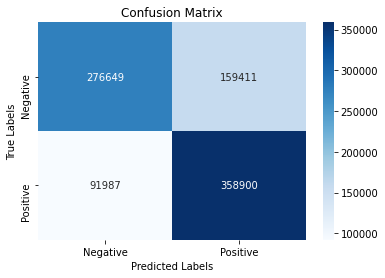

In [40]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        # for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           

      for batch in test_loader:

        text, text_len = batch.text    
        target = batch.sentiment

        # labels = labels.to(device)
        # titletext = titletext.to(device)
        # titletext_len = titletext_len.to(device)
        output = model(text, text_len)
        output = (output > threshold).int()

        y_pred.extend(output.tolist())
        y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('/content' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Below, we are going to see some visual error represenation in between the training and the validation.

Text(0.5, 1.0, 'Blue = val | Red = train')

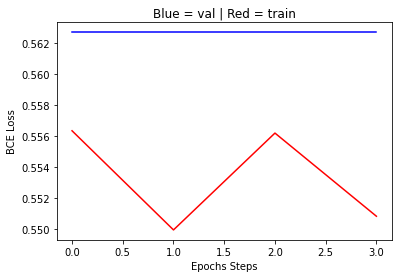

In [60]:
train_loss = plt.plot(train_lost, 'r')
validation_loss = plt.plot(val_loss, 'b')
plt.xlabel('Epochs Steps')
plt.ylabel('BCE Loss')
# plt.legend([train_loss, validation_loss,], ['train_loss','validation_loss'])

plt.title('Blue = val | Red = train')